In [1]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv("microchip_tests.txt",
                   header=None,
                   names=("test1", "test2", "released")
                )

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [4]:
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
data.tail()

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


In [9]:
X = data.iloc[:, :2].values

In [10]:
y = data.iloc[:, 2].values

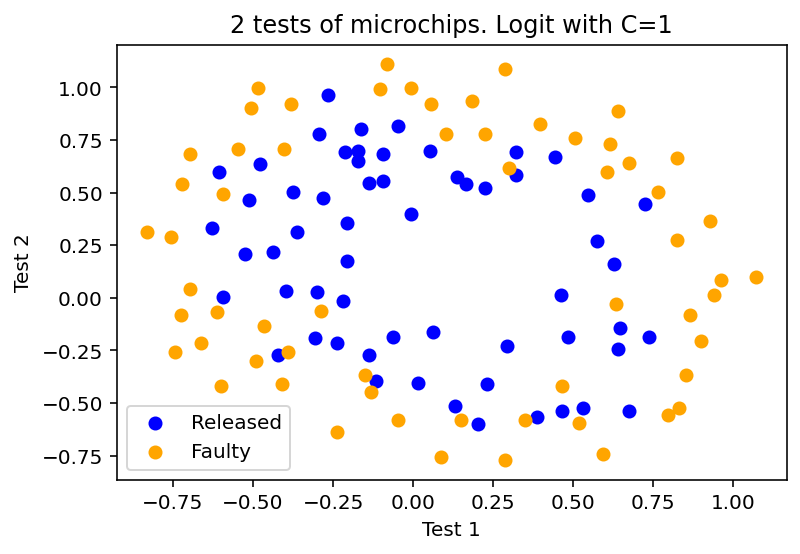

In [16]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

In [17]:
def plot_boundary(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

In [18]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [19]:
X_poly.shape

(118, 36)

Accuracy on training set: 0.839


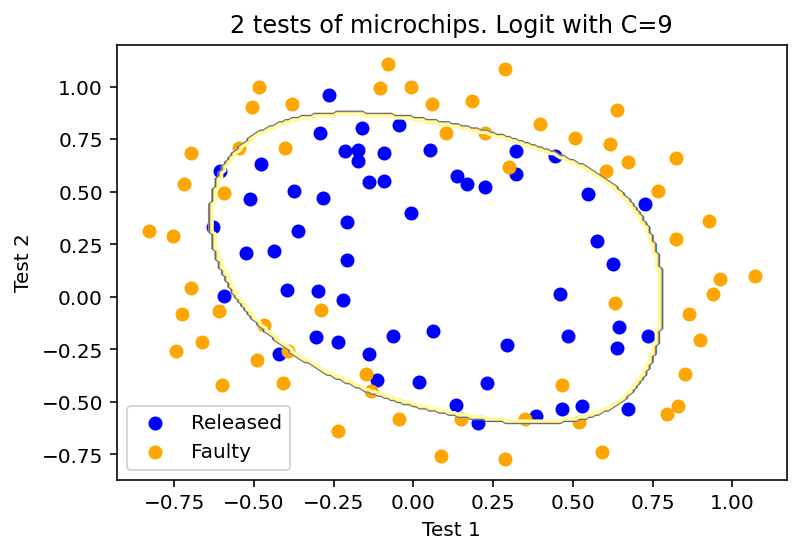

In [48]:
#Можно поиграться с параметром С.
#Если низкий, то модель недообучается и аккур будет низкий тоже
#Если очень большое, то переобучается, начинает рисовать близко к точкам и аккур опять уменьшится
C = 9

logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

In [35]:
#Как определить оптимальные параметры
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_poly, y);

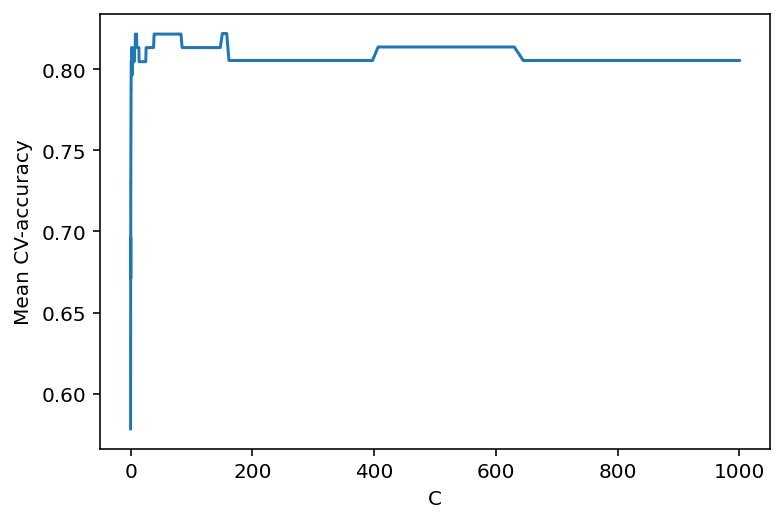

In [36]:
#Рисуем зависимость скор от С
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

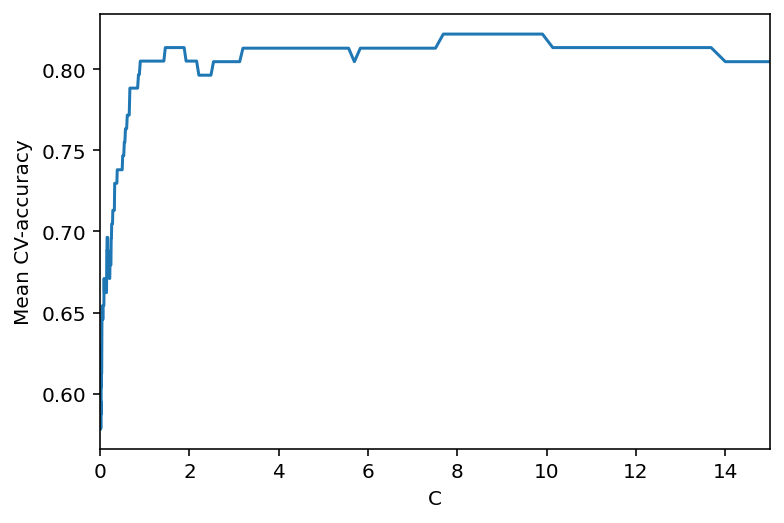

In [49]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy")
plt.xlim((0, 15));         # Лучшая часть графика, лучше всего - 8-9